<a href="https://colab.research.google.com/github/sabshaik27/Deep-Learning/blob/main/RNN/LSTM_for_text_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# to download the file https://www.kaggle.com/uciml/sms-spam-collection-dataset/data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving spam.csv to spam.csv
User uploaded file "spam.csv" with length 503663 bytes


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Text(0.5, 1.0, 'Number of ham and spam messages')

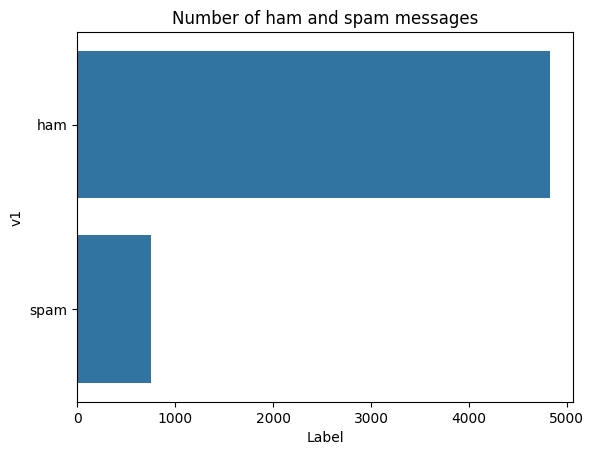

In [6]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [7]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [9]:
# A good first step when working with text is to split it into words. Words are called tokens and the process of splitting text into tokens is called tokenization.
# Keras provides the text_to_word_sequence() function that you can use to split text into a list of words...

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
# Keras Embedding Layer. Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer
# encoded, so that each word is represented by a unique integer. ... It can be used to load a pre-trained word embedding model, a type of transfer learning

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,337 (376.32 KB)

 Trainable params: 96,337 (376.32 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states
# and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential
#  or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - accuracy: 0.8029 - loss: 0.4747 - val_accuracy: 0.9694 - val_loss: 0.2527
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.9592 - loss: 0.1885 - val_accuracy: 0.9778 - val_loss: 0.0861
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.9823 - loss: 0.0704 - val_accuracy: 0.9757 - val_loss: 0.0781
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.9874 - loss: 0.0521 - val_accuracy: 0.9873 - val_loss: 0.0501
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 274ms/step - accuracy: 0.9921 - loss: 0.0375 - val_accuracy: 0.9895 - val_loss: 0.0490
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.9925 - loss: 0.0356 - val_accuracy: 0.9873 - val_loss: 0.0524


In [13]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [14]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9772 - loss: 0.0761


In [15]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.063
  Accuracy: 0.982


In [16]:
Testing_context = ["Oh k...i'm watching here:)"]

txts = tok.texts_to_sequences(Testing_context)
txts = sequence.pad_sequences(txts, maxlen=max_len)

In [17]:
preds = model.predict(txts)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
[[0.00137337]]
